# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import zero_one_loss

%matplotlib inline

In [2]:
from utils.data_gen import compute_bayes_risk_binary, compute_bayes_risk_binary_label_shift,\
    generate_2d_example

from utils.concentrations import hoeffding_ci_lower_limit,\
    hoeffding_ci_upper_limit
from utils.concentrations import pm_bernstein_ci_upper_limit,\
    pm_bernstein_ci_lower_limit

from utils.concentrations import pm_bernstein_lower_limit, pm_bernstein_upper_limit
from utils.concentrations import pm_hoeffding_upper_limit, pm_hoeffding_lower_limit

from utils.data_gen import LDA_predictor

from utils.concentrations import betting_ci_lower_limit, betting_ci_upper_limit

from utils.tests import Drop_tester,misclas_losses

In [3]:
sns.set(
    style="whitegrid",
    font_scale=1.4,
    rc={
        "lines.linewidth": 2,
        #             "axes.facecolor": ".9",
        'figure.figsize': (12, 6)
    })
sns.set_palette('Set2')
matplotlib.rcParams['text.usetex'] = True

In [4]:
%load_ext autoreload
%autoreload 2

# Data generation

In [166]:
num_of_repeats = 250
num_of_batches_to_sample = 80

size_of_batch = 20
size_source_sample = 1000

In [167]:
increase_tracker = 0

In [168]:
mu_1 = np.array([1, 0])
mu_0 = np.array([-1, 0])
prob_class_1 = 0.25
prob_class_0 = 1 - prob_class_1
cov = np.eye(2)

In [169]:
X_val_source, y_val_source = generate_2d_example(0.25, mu_0, mu_1,
                                                 size_source_sample)

In [170]:
class_1_probs = list()

In [171]:
batches_per_prob = 10

In [172]:
class_1_probs += np.repeat(0.25,batches_per_prob).tolist()
class_1_probs += np.repeat(0.35,batches_per_prob).tolist()
class_1_probs += np.repeat(0.45,batches_per_prob).tolist()
class_1_probs += np.repeat(0.55,batches_per_prob).tolist()
class_1_probs += np.repeat(0.65,batches_per_prob).tolist()
class_1_probs += np.repeat(0.75,batches_per_prob).tolist()
class_1_probs += np.repeat(0.85,num_of_batches_to_sample - 6 * batches_per_prob).tolist()

In [173]:
len(class_1_probs)

80

In [174]:
clf = LDA_predictor()

clf.mean_class_0 = mu_0
clf.mean_class_1 = mu_1
clf.class_0_prior = prob_class_0
clf.class_1_prior = prob_class_1

In [175]:
eps_tol = 0

In [176]:
tester_conj_bernstein = Drop_tester()

tester_conj_bernstein.eps_tol = eps_tol
tester_conj_bernstein.target_conc_type = 'conj-bern'


In [177]:
conj_bern_target_lower_bounds = list()
conj_bern_source_upper_bounds = list()

In [178]:
for cur_sim in range(num_of_repeats):
    conj_bern_target_lower_bounds+=[[]]
    X_val_source, y_val_source = generate_2d_example(0.25, mu_0, mu_1,
                                                     size_source_sample)

    y_pred_val = clf.predict(X_val_source)
    ind_loss_source = misclas_losses(y_pred_val, y_val_source)

    tester_conj_bernstein.estimate_risk_source(ind_loss_source)

    conj_bern_source_upper_bounds += [
        tester_conj_bernstein.source_rejection_threshold
    ]

    X_target = []
    y_target = []

    for cur_class_1_prob in class_1_probs:
        X_new_target, y_new_target = generate_2d_example(
            cur_class_1_prob, mu_0, mu_1, size_of_batch)

        X_target += [X_new_target]
        y_target += [y_new_target]

    X_target = np.vstack(X_target)
    y_target = np.hstack(y_target)

    y_pred_target = clf.predict(X_target)
    ind_loss_target = misclas_losses(y_pred_target, y_target)

    for cur_batch in range(num_of_batches_to_sample):
        cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
        tester_conj_bernstein.estimate_risk_target(cur_losses)
        conj_bern_target_lower_bounds[cur_sim] += [
            tester_conj_bernstein.target_risk_lower_bound
        ]

In [179]:
sample_sizes = np.arange(size_of_batch,size_of_batch*(num_of_batches_to_sample+1), step=size_of_batch)

In [180]:
len(sample_sizes)

80

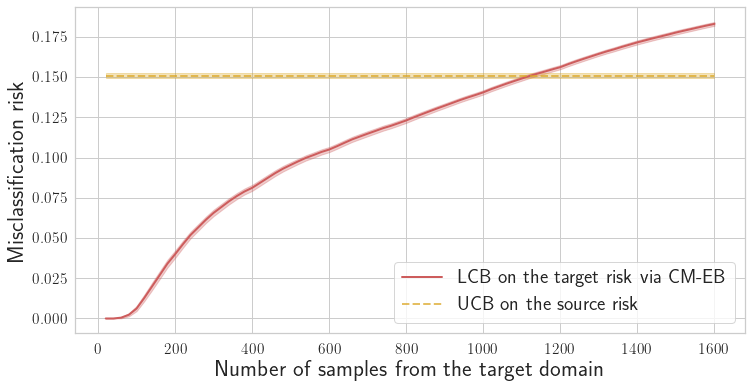

In [182]:
l1, = plt.plot(sample_sizes,np.mean(conj_bern_target_lower_bounds, axis=0),
               color='indianred')


plt.fill_between(
    sample_sizes,
    y1=np.mean(conj_bern_target_lower_bounds, axis=0) -
    2 * np.std(conj_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(conj_bern_target_lower_bounds, axis=0) +
    2 * np.std(conj_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='indianred')

l2, = plt.plot(sample_sizes,
               np.repeat(np.mean(conj_bern_source_upper_bounds, axis=0),num_of_batches_to_sample
                         ),
               linestyle='dashed',
               color='goldenrod',
               alpha=0.7)

plt.fill_between(
    sample_sizes,
    y1=np.mean(conj_bern_source_upper_bounds, axis=0) - 2 *
    np.std(conj_bern_source_upper_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(conj_bern_source_upper_bounds, axis=0) +
    2 * np.std(conj_bern_source_upper_bounds, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='goldenrod')

categories = [
     'LCB on the target risk via CM-EB','UCB on the source risk'
]

leg4 = plt.legend([l1, l2],
                  categories,
                  loc=4,
                  ncol=1,
                  prop={'size': 20})  # Two columns, horizontal group labels

plt.ylabel('Misclassification risk', fontsize=23)
plt.xlabel('Number of samples from the target domain', fontsize=23)
plt.savefig('img/gradual_change.pdf', bbox_inches='tight')

In [112]:
conj_bern_target_lower_bounds

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.022889261300762714,
 0.04195205278501282,
 0.04175468455189922,
 0.041429784490946406,
 0.04578490825621781,
 0.04556783522680004,
 0.050922545924624224,
 0.0588216554429023,
 0.0646834619501955,
 0.06819385534191476,
 0.07895258919756418,
 0.0894275656112861,
 0.09545576772325498,
 0.09999515651914787,
 0.10747447241134726,
 0.11010528383691401,
 0.1141576588255856,
 0.1166107095607631,
 0.12129729984630166,
 0.12255029647197958,
 0.12742868169412871,
 0.12903575920974691,
 0.12941324569787774,
 0.13557455315925887,
 0.1358845664340108,
 0.13788148695620947,
 0.13899063373011747,
 0.13896163162270153,
 0.14483511486587575,
 0.14683719433665948,
 0.1502245713948177,
 0.15141548398415391,
 0.15253481107368314,
 0.1572818993559109,
 0.15938365717511654,
 0.16038401235015345,
 0.16088803904011584,
 0.16420895941284536,
 0.1662921920712003,
 0.167021260305191,
 0.16700600702301457,
 0.1678058374892488,
 0.1684147126142052,
 0.16840041528503907,
 0.169521253

In [ ]:
l1, = plt.plot(bet_target_sample_sizes[0],
               np.mean(bet_target_lower_bounds, axis=0),
               label='Lower bound on the target risk, Betting',
               color='indianred')

plt.fill_between(
    bet_target_sample_sizes[0],
    y1=np.mean(bet_target_lower_bounds, axis=0) -
    2 * np.std(bet_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(bet_target_lower_bounds, axis=0) +
    2 * np.std(bet_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='indianred')

l2, = plt.plot(pm_bern_target_sample_sizes[0],
               np.mean(pm_bern_target_lower_bounds, axis=0),
               label='Lower bound on the target risk, PM-EB',
               color='steelblue')

plt.fill_between(
    pm_bern_target_sample_sizes[0],
    y1=np.mean(pm_bern_target_lower_bounds, axis=0) -
    2 * np.std(pm_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(pm_bern_target_lower_bounds, axis=0) +
    2 * np.std(pm_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='steelblue')

l3, = plt.plot(conj_bern_target_sample_sizes[0],
               np.mean(conj_bern_target_lower_bounds, axis=0),
               label='Lower bound on the target risk,  conj mixtures',
               color='mediumaquamarine')

plt.fill_between(
    conj_bern_target_sample_sizes[0],
    y1=np.mean(conj_bern_target_lower_bounds, axis=0) - 2 *
    np.std(conj_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(conj_bern_target_lower_bounds, axis=0) + 2 *
    np.std(conj_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='mediumaquamarine')

p5, = plt.plot([0.15], marker='None', linestyle='None', label='dummy-tophead')

l4, = plt.plot(conj_bern_target_sample_sizes[0],
               np.repeat(np.mean(conj_bern_rej_thrs, axis=0),
                         len(conj_bern_target_sample_sizes[0])),
               linestyle='dashed',
               color='goldenrod',
               alpha=0.7)

# l4 = plt.axhline(y=np.mean(conj_bern_rej_thrs),
#                  linestyle='dashed',
#                  c='goldenrod',
#                  alpha=0.7)

plt.fill_between(
    conj_bern_target_sample_sizes[0],
    y1=np.mean(conj_bern_rej_thrs, axis=0) - 2 *
    np.std(conj_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(conj_bern_rej_thrs, axis=0) +
    2 * np.std(conj_bern_rej_thrs, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='goldenrod')

categories = [
    'UCB on the source risk', r'$\textbf{LCB on the target risk via:}$ ',
    'Betting', 'PM-EB', 'CM-EB'
]

leg4 = plt.legend([l4, p5, l1, l2, l3],
                  categories,
                  loc=4,
                  ncol=1,
                  prop={'size': 20})  # Two columns, horizontal group labels

plt.ylabel('Misclassification risk', fontsize=23)
plt.xlabel('Number of samples from the target domain', fontsize=23)
# plt.savefig('img/lower_bounds_misclas.pdf', bbox_inches='tight')